# CS-230: ASVSpoof 2019 Challenge: Utility Functions

In [3]:
#!/usr/bin/env python
__author__      = "Daniel Evert"
__purpsose__    = "CS-230 Project for Winter 2020"

import numpy as np     
import sys
import soundfile as sf  
from pylab import *
from os import listdir
from os.path import isfile,join
import librosa
import librosa.display
import pickle

def get_asvspoof_file_names(target_path):
    target_dict = dict()
    with open(target_path,'r') as f:
        for lines in f:
            line = lines.strip("\n")
            line_split=line.split(" ")
            identifier = line_split[0]
            file_path = line_split[1]
            attack = line_split[3]
            if line_split[4] == 'bonafide':
                target = 0
            else:
                target = 1
#             target_dict[file_path] = [identifier,target]
            target_dict[file_path] = [identifier,target,attack]
    return target_dict

def len_audio_file(path
                  ,dic
                  ,freq=16000):
    """Get Length of Audio Files"""
    import soundfile as sf
    
    seconds_list = []
    dir_path = path
    for idx,key in enumerate(eval_dict.keys()):
        clip, sample_rate = sf.read(dir_path + "\\"+key + ".flac")
        seconds = len(clip)/freq
        seconds_list.append(seconds)
    return seconds_list
    
    
def attack_agg(dic):
    """Get Attack Aggregates"""
    
    new_dict=dict()
    for key in dic.keys():
        attack = dic[key][2]
        if attack not in new_dict:
            new_dict[attack] = 0
        else:
            new_dict[attack]+=1

    return new_dict

def generate_mel(file_name
                ,n_fft = 1024
                ,hop_length = 128
                ,n_mels = 128
                ,f_min = 20
                ,f_max = 8000
                ,sample_rate = 16000):
    """Generate Mel Spectrogram from Audio file (FLAC)
    """
    clip, sample_rate = sf.read(file_name)
    mel_spec = librosa.feature.melspectrogram(clip
                                          , n_fft=n_fft
                                          , hop_length=hop_length
                                          , n_mels=n_mels
                                          , sr=sample_rate
                                          , power=1.0
                                          , fmin=f_min
                                          , fmax=f_max)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

    return mel_spec_db,clip


def trim_mel(mel
             ,get_rms
             ,threshold = 0.1):
    """Trim Mel Spectrogram based off of RMS (Energy)
       so as to reduce noise 
    """
    #Get array producd by rms
    get_rms = get_rms[0]
    start = 0
    sliced = get_rms[i]
    while sliced < threshold:
        sliced = get_rms[start]
        start+=1
        #Check to limit amoutn of trimming
        if start > 2000:
            break
    end = 1
    sliced = get_rms[-1]
    while sliced < threshold:
        sliced = get_rms[-end]
        end+=1
        #Check to limit amoutn of trimming
        if end > 2000:
            break
            
    #Check if entire file is less than threshold
    if abs(start) + abs(end) > len(get_rms):
        return mel[0]
    #Transpose so as to reduce rows of data
    trim_mels = mel.T[start:(len(get_rms)-end)]  
    
    return trim_mels.T

def create_partition(file_names
                     ,dir_path
                     ,output_path
                     ,by=5000
                     ):
    """Create Data Partition so as to reduce upload
       to AWS
    """
    #Keep Record of audio files not at least 48 in time domain length
    num_deleted = []
    #Temporary Dictionary so as to load the partition
    mel_dict={}
    #Loop through all audio files
    for idx,key in enumerate(file_names,start=0):
        #Generate mel
        mel,clip = generate_mel(file_name = dir_path + '\\'+key+'.flac')
        #Generate RMS Energy for Mel
        get_rms = librosa.feature.rms(clip,hop_length = 128)
        #Apply trimming with threshold logic of 0.08
        mel = trim_mel(mel = mel,get_rms=get_rms,threshold = 0.08)
        #Remove records if less than 48 after trimming
        if mel.shape[1] < 48:
            num_deleted.append(key)
            continue
        
        #Add keys & valuese to mel_dict
        mel_dict[key] = dict()
        mel_dict[key]['data'] = mel
        mel_dict[key]['target'] = file_names[key]
        
        #If partition met, export dictionary into pickle
        if idx % by == 0:
            with open(output_path+"_"+str(cnt) + ".pkl",'wb') as f:
                pickle.dump(mel_dict, f)
                mel_dict=dict()
            
    #Export dictionary to pickle (last export)
    with open(output_path+"_"+str(cnt) + ".pkl",'wb') as f:
        pickle.dump(mel_dict, f)
        mel_dict=dict()
        
def get_asvspoof_file_names(target_path):
    """Load files provided by ASVSpoof and 
       and put into Dictioanry
    """
    target_dict = dict()
    with open(target_path,'r') as f:
        for lines in f:
            line = lines.strip("\n")
            line_split=line.split(" ")
            identifier = line_split[0]
            file_path = line_split[1]
            attack = line_split[3]
            if line_split[2] == 'bonafide':
                target = 0
            else:
                target = 1
            target_dict[file_path] = [identifier,target,attack]
    return target_dict



def generate_time_step_samples(np_array
                               ,ts_length = 48
                               ,offset = 5):
    """Generate Sliding Window for Time Steps"""

    list_of_arrays = []
    col_dim = np_array.shape[0]
    time_len = np_array.shape[1]

    start = 0
    end = ts_length

    while(end <= time_len):
        trn_data = np_array[:,start:end]
        trn_data = np.reshape(trn_data.T,(ts_length,col_dim,1),order='C')
        list_of_arrays.append(trn_data)

        start+=offset
        end+=offset
        
    new_array = np.stack(list_of_arrays)
    
    return new_array

def get_sample_size(dic,ts_length,offset):
    """Generate Sample Size (so to know size of array)
       in order to increase efficiency
    """
    sample_size = 0
    for idx,key in enumerate(dic.keys(),start=0):
        if idx == 0:
            X = [generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)]
            sample_size += X[0].shape[0]
        else:
            temp_array = generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)
            sample_size += temp_array.shape[0]
    return sample_size

def generate_XY_fast(dic,ts_length,offset,sample_size):
    """Generate X & Y with pre-propulated numpy array"""
    arr = np.zeros((sample_size,ts_length,128,1),dtype=np.float32)
    tot_len=0
    for idx,key in enumerate(dic.keys()):
        if idx == 0:
            X = generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)
            for i in range(X.shape[0]):
                arr[tot_len] = X[i]
                tot_len+=1
            Y = [dic[key]['target'][1]]*len(X)
        else:
            temp_array = generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)
            temp_y = [dic[key]['target'][1]]*temp_array.shape[0]
            for i in range(temp_array.shape[0]):
                arr[tot_len] = temp_array[i]
                tot_len+=1
            Y = Y + temp_y
    return arr,Y


def get_sample_size_key(dic,key,ts_length,offset):
    """Generate Sample Size (so to know size of array)
       in order to increase efficiency
    """
    sample_size = 0
    X = [generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)]
    sample_size += X[0].shape[0]
    return sample_size
    

def generate_XY_fast_key(dic,key,ts_length,offset,sample_size):
    """Generate X & Y with pre-propulated numpy array"""
    arr = np.zeros((sample_size,ts_length,128,1),dtype=np.float32)
    tot_len=0
    X = generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)
    for i in range(X.shape[0]):
        arr[tot_len] = X[i]
        tot_len+=1
    Y = [dic[key]['target'][1]]*len(X)
    
    return arr,Y

def normalization(X):
    """Normalize 48-7 Timestep"""
    return (X- -53.15337)/17.33285


# t-DCF Functions Provided by ASVspoof

In [ ]:
import numpy as np
import sys

def obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold):

    # False alarm and miss rates for ASV
    Pfa_asv = sum(non_asv >= asv_threshold) / non_asv.size
    Pmiss_asv = sum(tar_asv < asv_threshold) / tar_asv.size

    # Rate of rejecting spoofs in ASV
    if spoof_asv.size == 0:
        Pmiss_spoof_asv = None
    else:
        Pmiss_spoof_asv = np.sum(spoof_asv < asv_threshold) / spoof_asv.size

    return Pfa_asv, Pmiss_asv, Pmiss_spoof_asv


def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size)))

    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds


def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]


def compute_tDCF(bonafide_score_cm, spoof_score_cm, Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, cost_model, print_cost):
    """
    Compute Tandem Detection Cost Function (t-DCF) [1] for a fixed ASV system.
    In brief, t-DCF returns a detection cost of a cascaded system of this form,

      Speech waveform -> [CM] -> [ASV] -> decision

    where CM stands for countermeasure and ASV for automatic speaker
    verification. The CM is therefore used as a 'gate' to decided whether or
    not the input speech sample should be passed onwards to the ASV system.
    Generally, both CM and ASV can do detection errors. Not all those errors
    are necessarily equally cost, and not all types of users are necessarily
    equally likely. The tandem t-DCF gives a principled with to compare
    different spoofing countermeasures under a detection cost function
    framework that takes that information into account.

    INPUTS:

      bonafide_score_cm   A vector of POSITIVE CLASS (bona fide or human)
                          detection scores obtained by executing a spoofing
                          countermeasure (CM) on some positive evaluation trials.
                          trial represents a bona fide case.
      spoof_score_cm      A vector of NEGATIVE CLASS (spoofing attack)
                          detection scores obtained by executing a spoofing
                          CM on some negative evaluation trials.
      Pfa_asv             False alarm (false acceptance) rate of the ASV
                          system that is evaluated in tandem with the CM.
                          Assumed to be in fractions, not percentages.
      Pmiss_asv           Miss (false rejection) rate of the ASV system that
                          is evaluated in tandem with the spoofing CM.
                          Assumed to be in fractions, not percentages.
      Pmiss_spoof_asv     Miss rate of spoof samples of the ASV system that
                          is evaluated in tandem with the spoofing CM. That
                          is, the fraction of spoof samples that were
                          rejected by the ASV system.
      cost_model          A struct that contains the parameters of t-DCF,
                          with the following fields.

                          Ptar        Prior probability of target speaker.
                          Pnon        Prior probability of nontarget speaker (zero-effort impostor)
                          Psoof       Prior probability of spoofing attack.
                          Cmiss_asv   Cost of ASV falsely rejecting target.
                          Cfa_asv     Cost of ASV falsely accepting nontarget.
                          Cmiss_cm    Cost of CM falsely rejecting target.
                          Cfa_cm      Cost of CM falsely accepting spoof.

      print_cost          Print a summary of the cost parameters and the
                          implied t-DCF cost function?

    OUTPUTS:

      tDCF_norm           Normalized t-DCF curve across the different CM
                          system operating points; see [2] for more details.
                          Normalized t-DCF > 1 indicates a useless
                          countermeasure (as the tandem system would do
                          better without it). min(tDCF_norm) will be the
                          minimum t-DCF used in ASVspoof 2019 [2].
      CM_thresholds       Vector of same size as tDCF_norm corresponding to
                          the CM threshold (operating point).

    NOTE:
    o     In relative terms, higher detection scores values are assumed to
          indicate stronger support for the bona fide hypothesis.
    o     You should provide real-valued soft scores, NOT hard decisions. The
          recommendation is that the scores are log-likelihood ratios (LLRs)
          from a bonafide-vs-spoof hypothesis based on some statistical model.
          This, however, is NOT required. The scores can have arbitrary range
          and scaling.
    o     Pfa_asv, Pmiss_asv, Pmiss_spoof_asv are in fractions, not percentages.

    References:

      [1] T. Kinnunen, K.-A. Lee, H. Delgado, N. Evans, M. Todisco,
          M. Sahidullah, J. Yamagishi, D.A. Reynolds: "t-DCF: a Detection
          Cost Function for the Tandem Assessment of Spoofing Countermeasures
          and Automatic Speaker Verification", Proc. Odyssey 2018: the
          Speaker and Language Recognition Workshop, pp. 312--319, Les Sables d'Olonne,
          France, June 2018 (https://www.isca-speech.org/archive/Odyssey_2018/pdfs/68.pdf)

      [2] ASVspoof 2019 challenge evaluation plan
          TODO: <add link>
    """


    # Sanity check of cost parameters
    if cost_model['Cfa_asv'] < 0 or cost_model['Cmiss_asv'] < 0 or \
            cost_model['Cfa_cm'] < 0 or cost_model['Cmiss_cm'] < 0:
        print('WARNING: Usually the cost values should be positive!')

    if cost_model['Ptar'] < 0 or cost_model['Pnon'] < 0 or cost_model['Pspoof'] < 0 or \
            np.abs(cost_model['Ptar'] + cost_model['Pnon'] + cost_model['Pspoof'] - 1) > 1e-10:
        sys.exit('ERROR: Your prior probabilities should be positive and sum up to one.')

    # Unless we evaluate worst-case model, we need to have some spoof tests against asv
    if Pmiss_spoof_asv is None:
        sys.exit('ERROR: you should provide miss rate of spoof tests against your ASV system.')

    # Sanity check of scores
    combined_scores = np.concatenate((bonafide_score_cm, spoof_score_cm))
    if np.isnan(combined_scores).any() or np.isinf(combined_scores).any():
        sys.exit('ERROR: Your scores contain nan or inf.')

    # Sanity check that inputs are scores and not decisions
    n_uniq = np.unique(combined_scores).size
    if n_uniq < 3:
        sys.exit('ERROR: You should provide soft CM scores - not binary decisions')

    # Obtain miss and false alarm rates of CM
    Pmiss_cm, Pfa_cm, CM_thresholds = compute_det_curve(bonafide_score_cm, spoof_score_cm)

    # Constants - see ASVspoof 2019 evaluation plan
    C1 = cost_model['Ptar'] * (cost_model['Cmiss_cm'] - cost_model['Cmiss_asv'] * Pmiss_asv) - \
         cost_model['Pnon'] * cost_model['Cfa_asv'] * Pfa_asv
    C2 = cost_model['Cfa_cm'] * cost_model['Pspoof'] * (1 - Pmiss_spoof_asv)

    # Sanity check of the weights
    if C1 < 0 or C2 < 0:
        sys.exit('You should never see this error but I cannot evalute tDCF with negative weights - please check whether your ASV error rates are correctly computed?')

    # Obtain t-DCF curve for all thresholds
    tDCF = C1 * Pmiss_cm + C2 * Pfa_cm

    # Normalized t-DCF
    tDCF_norm = tDCF / np.minimum(C1, C2)

    # Everything should be fine if reaching here.
    if print_cost:

        print('t-DCF evaluation from [Nbona={}, Nspoof={}] trials\n'.format(bonafide_score_cm.size, spoof_score_cm.size))
        print('t-DCF MODEL')
        print('   Ptar         = {:8.5f} (Prior probability of target user)'.format(cost_model['Ptar']))
        print('   Pnon         = {:8.5f} (Prior probability of nontarget user)'.format(cost_model['Pnon']))
        print('   Pspoof       = {:8.5f} (Prior probability of spoofing attack)'.format(cost_model['Pspoof']))
        print('   Cfa_asv      = {:8.5f} (Cost of ASV falsely accepting a nontarget)'.format(cost_model['Cfa_asv']))
        print('   Cmiss_asv    = {:8.5f} (Cost of ASV falsely rejecting target speaker)'.format(cost_model['Cmiss_asv']))
        print('   Cfa_cm       = {:8.5f} (Cost of CM falsely passing a spoof to ASV system)'.format(cost_model['Cfa_cm']))
        print('   Cmiss_cm     = {:8.5f} (Cost of CM falsely blocking target utterance which never reaches ASV)'.format(cost_model['Cmiss_cm']))
        print('\n   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), s=CM threshold)')

        if C2 == np.minimum(C1, C2):
            print('   tDCF_norm(s) = {:8.5f} x Pmiss_cm(s) + Pfa_cm(s)\n'.format(C1 / C2))
        else:
            print('   tDCF_norm(s) = Pmiss_cm(s) + {:8.5f} x Pfa_cm(s)\n'.format(C2 / C1))

    return tDCF_norm, CM_thresholds


# Get File Paths

In [4]:
#File Paths to CM-MetaData
dev_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_cm_protocols\\ASVspoof2019.LA.cm.dev.trl.txt'
train_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_cm_protocols\\ASVspoof2019.LA.cm.train.trn.txt'
eval_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_cm_protocols\\ASVspoof2019.LA.cm.eval.trl.txt'

#Directory Paths to Audio Files   
eval_dir_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_eval\\flac'
train_dir_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_train\\flac'
dev_dir_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_dev\\flac'

#Get Metadata into Dictionary
train_dict = get_asvspoof_file_names(train_path)
dev_dict = get_asvspoof_file_names(dev_path)
eval_dict = get_asvspoof_file_names(eval_path)

In [ ]:
# Print Overall Counts of Spoofed Data for the Countermeasures
print("Training: Count and Spoof Count: ",len([k[1] for k in train_dict.values()]),sum([k[1] for k in train_dict.values()]))
print("Development: Count and Spoof Count: ",len([k[1] for k in dev_dict.values()]),sum([k[1] for k in dev_dict.values()]))
print("Eval: Count and Spoof Count: ",len([k[1] for k in eval_dict.values()]),sum([k[1] for k in eval_dict.values()]))

In [ ]:
#Overview of Training Dataset
print(mean(seconds_list),len(seconds_list),var(seconds_list),min(seconds_list),max(seconds_list))

In [ ]:
#Overview of Dev Dataset
print(mean(seconds_list),len(seconds_list),var(seconds_list),min(seconds_list),max(seconds_list))

In [ ]:
#Overview of Eval Dataset
print(mean(seconds_list),len(seconds_list),var(seconds_list),min(seconds_list),max(seconds_list))

In [ ]:
new_dev_path = 'C:\\Users\\15126\\Downloads\\ASVspoof\\LA\\LA\\ASVspoof2019_LA_asv_protocols\\ASVspoof2019.LA.asv.dev.gi.trl.txt'
dev_dict = get_asvspoof_file_names(new_dev_path)

create_partition(file_names = train_dict,dir_path =train_dir_path,output_path = 'C:\\Users\\15126\\Desktop\\stanford\\train')   
create_partition(file_names = dev_dict
                     ,dir_path = dev_dir_path
                     ,output_path = 'C:\\Users\\15126\\Desktop\\stanford\\dev')
create_partition(file_names = eval_dict,dir_path = eval_dir_path,output_path = 'C:\\Users\\15126\\Desktop\\stanford\\eval') 


In [93]:
from keras.models import model_from_json
import keras 

#Pull back Models

json_path_m1 = 'C:\\Users\\15126\\Desktop\\stanford\\best_model_5AB_76_16.hdf5.json'
weight_path_m1 = 'C:\\Users\\15126\\Desktop\\stanford\\best_model_5AB_64_12.hdf5' 

json_path_m2 = 'C:\\Users\\15126\\Desktop\\stanford\\z_4conv_48_7_LSTM_512ep_9weight_v3.hdf5.json'
weight_path_m2 = 'C:\\Users\\15126\\Desktop\\stanford\\z_4conv_48_7_LSTM_512ep_9weight_v3.hdf5' 

json_path_m3 = 'C:\\Users\\15126\\Desktop\\stanford\\z_best_model_48_5_ADAM_GRU_128_RANDDEV_9wght_v2.hdf5.json'
weight_path_m3 = 'C:\\Users\\15126\\Desktop\\stanford\\z_best_model_48_5_ADAM_GRU_128_RANDDEV_9wght_v2.hdf5' 

json_path_m4 = 'C:\\Users\\15126\\Desktop\\stanford\\z_best_model_48_5_ADAM_GRU_512_RANDDEV_9wght_v1.hdf5.json'
weight_path_m4 = 'C:\\Users\\15126\\Desktop\\stanford\\z_best_model_48_5_ADAM_GRU_512_RANDDEV_9wght_v1.hdf5' 

json_path_m4 = 'C:\\Users\\15126\\Desktop\\stanford\\z_best_model_48_5_ADAM_GRU_512_RANDDEV_v1.hdf5.json'
weight_path_m4 = 'C:\\Users\\15126\\Desktop\\stanford\\z_best_model_48_5_ADAM_GRU_512_RANDDEV_v1.hdf5' 


def normalization_255(X):
    return X/255

opt1 = keras.optimizers.Nadam()
opt2 = keras.optimizers.Adam()

def load_keras_model(json_path,weight_path,optimizer):

    with open(json_path, 'r') as f:
        _model = model_from_json(f.read())

    _model.load_weights(weight_path)
    _model.summary()
    _model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])   
    return _model
    
m2 = load_keras_model(json_path = json_path_m2
                ,weight_path = weight_path_m2
                ,optimizer = opt2 )   
m3 = load_keras_model(json_path = json_path_m3
                ,weight_path = weight_path_m3
                ,optimizer = opt2 )    
m4 = load_keras_model(json_path = json_path_m4
                ,weight_path = weight_path_m4
                ,optimizer = opt2 )    

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 48, 65, 18)        1170      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 48, 65, 18)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 48, 32, 18)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 32, 18)        72        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 48, 32, 20)        380       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 48, 32, 20)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 48, 16, 20)       

# Example of Mel Spectrogram

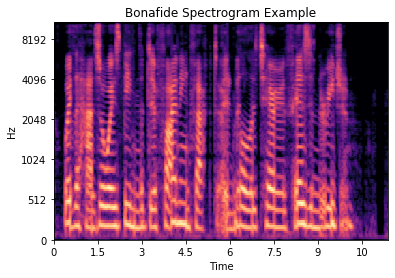

In [5]:
def generate_mel(file_name
                ,n_fft = 1024
                ,hop_length = 128
                ,n_mels = 128
                ,f_min = 20
                ,f_max = 8000
                ,sample_rate = 16000):
    """Generate Mel Spectrogram from Audio file (FLAC)
    """
    clip, sample_rate = sf.read(file_name)
    mel_spec = librosa.feature.melspectrogram(clip
                                          , n_fft=n_fft
                                          , hop_length=hop_length
                                          , n_mels=n_mels
                                          , sr=sample_rate
                                          , power=1.0
                                          , fmin=f_min
                                          , fmax=f_max)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max,top_db = 80)

    return mel_spec_db,clip,mel_spec

path = dev_dir_path + "\\" + 'LA_D_1002130' + ".flac"
mel_spec_db,clip,mel_spec = generate_mel(path)
plt.title("Bonafide Spectrogram Example")
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')

# Create Data Partitions

In [171]:
create_partition(file_names = train_dict,dir_path =train_dir_path,output_path = 'C:\\Users\\15126\\Desktop\\stanford\\train')   
create_partition(file_names = dev_dict
                     ,dir_path = dev_dir_path
                     ,output_path = 'C:\\Users\\15126\\Desktop\\stanford\\dev')
create_partition(file_names = eval_dict
                 ,dir_path = eval_dir_path
                 ,output_path = 'C:\\Users\\15126\\Desktop\\stanford\\eval') 

(128, 40) 158
deleted sample:  LA_E_1350979
(128, 28) 444
deleted sample:  LA_E_5595026
(128, 41) 807
deleted sample:  LA_E_1673131
(128, 38) 1317
deleted sample:  LA_E_5388663
(128, 39) 1555
deleted sample:  LA_E_9477263
(128, 17) 2080
deleted sample:  LA_E_4852262
(128, 41) 2964
deleted sample:  LA_E_9862567
(128, 41) 2970
deleted sample:  LA_E_2636404
(128, 38) 3123
deleted sample:  LA_E_6584930
(128, 26) 3286
deleted sample:  LA_E_6234125
(128, 46) 3877
deleted sample:  LA_E_4087863
(128, 25) 4212
deleted sample:  LA_E_6558743
(128, 46) 4797
deleted sample:  LA_E_5054367
(128, 44) 5373
deleted sample:  LA_E_3581152
(128, 32) 5412
deleted sample:  LA_E_1410419
(128, 37) 7369
deleted sample:  LA_E_5500063
(128, 44) 7470
deleted sample:  LA_E_2667571
(128, 47) 7533
deleted sample:  LA_E_5616519
(128, 3) 8053
deleted sample:  LA_E_1080447
(128, 33) 10075
deleted sample:  LA_E_2763219
(128, 44) 10705
deleted sample:  LA_E_7266298
(128, 36) 10920
deleted sample:  LA_E_5832356
(128, 43) 1

# Train Data

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input,Reshape
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers import LSTM

X,Y = generate_time_step_samples(dev_data_dict[key]['data'])

def generate_XY_fast_key(dic,key,ts_length,offset,sample_size):
    """Generate X & Y with pre-propulated numpy array"""
    arr = np.zeros((sample_size,ts_length,128,1),dtype=np.float32)
    tot_len=0
    X = generate_time_step_samples(dic[key]['data'],ts_length=ts_length,offset=offset)
    for i in range(X.shape[0]):
        arr[tot_len] = X[i]
        tot_len+=1
    Y = [dic[key]['target'][1]]*len(X)
    
    return arr,Y

#generate 48-7 Samples
X,Y = generate_XY_fast(dic=training_dataset,ts_length = 48, offset = 7)
X,Y = generate_XY_fast(dic=val_dataset,ts_length = 48, offset = 7)
#generate 76-16 Samples
X,Y = generate_XY_fast(dic=training_dataset,ts_length = 76, offset = 16)

def cnn_48_7_m1(X,Y,X_dev,Y_dev):
    """Example Conv1D-LSTM Model"""    
    model = Sequential()
    #Conv1D
    model.add(TimeDistributed(Conv1D(filters=18
                                     ,kernel_size=64)
                              , input_shape=(time_steps, 128, 1)))
    #LeakyReLU
    keras.layers.LeakyReLU(alpha=0.3)
    #MaxPooling
    model.add(TimeDistributed(MaxPooling1D(2)))
    
    #Conv1D
    model.add(TimeDistributed(Conv1D(filters=20
                                     ,kernel_size=1)))
    #LeakyReLU
    keras.layers.LeakyReLU(alpha=0.3)
    #MaxPooling
    model.add(TimeDistributed(MaxPooling1D(2)))    
    
    #Conv1D
    model.add(TimeDistributed(Conv1D(filters=22
                                     ,kernel_size=1)))
    #LeakyReLU
    keras.layers.LeakyReLU(alpha=0.3)
    #MaxPooling
    model.add(TimeDistributed(MaxPooling1D(2)))    
    
    #Conv1D
    model.add(TimeDistributed(Conv1D(filters=24
                                     ,kernel_size=1)))
    #LeakyReLU
    keras.layers.LeakyReLU(alpha=0.3)
    #MaxPooling
    model.add(TimeDistributed(MaxPooling1D(2)))  
    
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.2))
    model.add(Dense(96))
    keras.layers.LeakyReLU(alpha=0.3)
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(96))
    model.add(BatchNormalization())
    
    model.summary()
    
    model.add(LSTM(48,return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(time_steps)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X,Y,validation_data=[X_dev,Y_dev]
             ,epoch = 100)


# Score Data

In [94]:
#Score Development Set With Model 

cnt=0
pred_list = []
Y_list = []
#Get Average of all sliding window predictions per audio file
avg_pred_list = []
#Get Max of all sliding window predictions per audio file
max_pred_list = []
#Get Min of all sliding window predictions per audio file
min_pred_list = []
#Get Median of all sliding window predictions per audio file
med_pred_list = []
size = 0
spoof_list = []

output_dir_path = ['C:\\Users\\15126\\Desktop\\stanford\\dev_5000.pkl'
                ,'C:\\Users\\15126\\Desktop\\stanford\\dev_10000.pkl'
                ,'C:\\Users\\15126\\Desktop\\stanford\\dev_15000.pkl'
                ,'C:\\Users\\15126\\Desktop\\stanford\\dev_20000.pkl'
                ,'C:\\Users\\15126\\Desktop\\stanford\\dev_24844.pkl'
               ]
# dev_dir_path = ['C:\\Users\\15126\\Desktop\\stanford\\eval_5000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_10000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_15000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_20000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_25000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_30000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_35000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_40000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_45000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_50000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_55000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_60000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_65000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_70000.pkl'
#                 ,'C:\\Users\\15126\\Desktop\\stanford\\eval_75000.pkl'
#                ]

model_list = ["C:\\Users\\15126\\Desktop\\stanford\\"]

scoring_list = [m2,m3,m4]

def add_scores_to_list(model
                       ,X
                       ,Y
                       ,dic
                       ,key
                      ,avg_list
                      ,max_list
                      ,min_list
                      ,med_list
                      ,norm='REAL'):
    if norm == 'REAL':
        predictions = model.predict(normalization(X))
    else:
        predictions = model.predict(X/255)
    
    avg_predict = sum(predictions)/len(predictions)
    max_predict = float(max(predictions))
    min_predict = float(min(predictions))
    med_predict = float(median(predictions))
    
    avg_list.append((avg_predict,Y[0],dic[key]['target'][2],key))
    max_list.append((max_predict,Y[0],dic[key]['target'][2],key))
    min_list.append((min_predict,Y[0],dic[key]['target'][2],key))
    med_list.append((med_predict,Y[0],dic[key]['target'][2],key))
    
def score_samples(data_path_list):

    #Get Average of all sliding window predictions per audio file
    avg_pred_list = []
    #Get Max of all sliding window predictions per audio file
    max_pred_list = []
    #Get Min of all sliding window predictions per audio file
    min_pred_list = []
    #Get Median of all sliding window predictions per audio file
    med_pred_list = []
    size = 0
    spoof_list = []
    
    for path in data_path_list:
        new_dict = dict()
        with open(path, "rb") as f:
            dev_data_dict = pickle.load(f)

        for idx,key in enumerate(dev_data_dict,start=0):

            X_temp = generate_time_step_samples(dev_data_dict[key]['data'])
            Y_temp = [dev_data_dict[key]['target'][2]]*X_temp.shape[0]  
                
            if idx % 100 == 0:
                print(idx)

            add_scores_to_list(m2
                           ,X=X_temp
                           ,Y=Y_temp
                           ,dic = dev_data_dict
                           ,key = key
                          ,avg_list = m2_avg_list
                          ,max_list = m2_max_list
                          ,min_list = m2_min_list
                          ,med_list = m2_med_list
                          )    
            add_scores_to_list(m3
                           ,X=X_temp
                           ,Y=Y_temp
                           ,dic = dev_data_dict
                           ,key = key
                          ,avg_list = m3_avg_list
                          ,max_list = m3_max_list
                          ,min_list = m3_min_list
                          ,med_list = m3_med_list)
            if idx % 500 == 0:
                print("Write File in case of crash")
                m_path = model_list[0]
                with open(m_path+"_m2_path" + "_avg","w") as f:
                    f.write(str(m2_avg_list))
                with open(m_path+"_m2_path" + "_max","w") as f:
                    f.write(str(m2_max_list))
                with open(m_path+"_m2_path" + "_min","w") as f:
                    f.write(str(m2_min_list))
                with open(m_path+"_m2_path" + "_med","w") as f:
                    f.write(str(m2_med_list))

                with open(m_path+"_m3_path" + "_avg","w") as f:
                    f.write(str(m3_avg_list))
                with open(m_path+"_m3_path" + "_max","w") as f:
                    f.write(str(m3_max_list))
                with open(m_path+"_m3_path" + "_min","w") as f:
                    f.write(str(m3_min_list))
                with open(m_path+"_m3_path" + "_med","w") as f:
                    f.write(str(m3_med_list))

#Generate Scored Lists
m2_avg_list = []
m2_max_list = []
m2_min_list = []
m2_med_list = []
m3_avg_list = []
m3_max_list = []
m3_min_list = []
m3_med_list = []
m4_avg_list = []
m4_max_list = []
m4_min_list = []
m4_med_list = []
                    
temp_dict = score_samples(data_path_list = output_dir_path )

0
(83, 48, 128, 1)
WRITING
100
(22, 48, 128, 1)
200
(13, 48, 128, 1)
300
(45, 48, 128, 1)
400
(58, 48, 128, 1)
500
(49, 48, 128, 1)
WRITING
600
(13, 48, 128, 1)
700
(33, 48, 128, 1)
800
(47, 48, 128, 1)
900
(34, 48, 128, 1)
1000
(28, 48, 128, 1)
WRITING
1100
(12, 48, 128, 1)
1200
(23, 48, 128, 1)
1300
(3, 48, 128, 1)
1400
(18, 48, 128, 1)
1500
(18, 48, 128, 1)
WRITING
1600
(21, 48, 128, 1)
1700
(18, 48, 128, 1)
1800
(44, 48, 128, 1)
1900
(26, 48, 128, 1)
2000
(95, 48, 128, 1)
WRITING
2100
(23, 48, 128, 1)
2200
(34, 48, 128, 1)
2300
(22, 48, 128, 1)
2400
(24, 48, 128, 1)
2500
(27, 48, 128, 1)
WRITING
2600
(36, 48, 128, 1)
2700
(34, 48, 128, 1)
2800
(90, 48, 128, 1)
2900
(64, 48, 128, 1)
3000
(26, 48, 128, 1)
WRITING
3100
(26, 48, 128, 1)
3200
(44, 48, 128, 1)
3300
(44, 48, 128, 1)
3400
(56, 48, 128, 1)
3500
(49, 48, 128, 1)
WRITING
3600
(226, 48, 128, 1)
3700
(36, 48, 128, 1)
3800
(47, 48, 128, 1)
3900
(61, 48, 128, 1)
4000
(14, 48, 128, 1)
WRITING
4100
(19, 48, 128, 1)
4200
(30, 48, 12

# Metrics

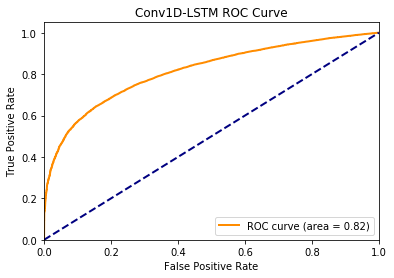

In [247]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Y, X)
metrics.auc(fpr, tpr)

roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Conv1D-LSTM ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision/Recall

0.2567094223281403
7199
0.6189161126255732
62644


No handles with labels found to put in legend.


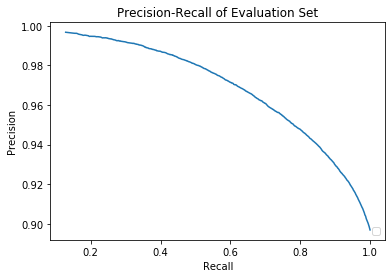

In [254]:
#List of Scored Values
pred_list = m3_avg_list

#Get Bonafide Summary
temp_pred_list = []
for i in range(len(pred_list)):
    if pred_list[i][1] == '-':
        temp_pred_list.append(pred_list[i][0])
print(sum(temp_pred_list)/len(temp_pred_list))
print(len(temp_pred_list))

# Get Spoof Summary
temp_pred_list = []
temp_pred_list = []
for i in range(len(pred_list)):
    if pred_list[i][1] != '-':
        temp_pred_list.append(pred_list[i][0])
print(sum(temp_pred_list)/len(temp_pred_list))
print(len(temp_pred_list))

precision_g = []
recall_g = []
for j in range(0,1000,1):
    j = j/1000
    above_cutoff = [i for i in pred_list if i[0] >= j] 
    below_cutoff = [i for i in pred_list if i[0] < j] 

    tp = len([i[0] for i in above_cutoff if i[1] != '-'])
    fp = len([i[0] for i in above_cutoff if i[1] == '-'])
    fn = len([i[0] for i in below_cutoff if i[1] != '-'])
    tn = len([i[0] for i in below_cutoff if i[1] == '-'])
    precision = tp/(fp+tp)
    recall = tp/(tp + fn)
    volume = tp+fp
    f1_score = 2*(precision*recall)/(precision+recall)

    precision_g.append(precision)
    recall_g.append(recall)
    
plt.plot(recall_g,precision_g)   
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall of Evaluation Set')
plt.legend(loc="lower right")
plt.show()

# ASV Scoring

In [ ]:
##### Get ASV Score Data ######
asv_score_file = 'C:\\Users\\15126\\Downloads\\ASVspoof\\LA\\LA\\ASVspoof2019_LA_asv_scores\\ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
asv_score_file = 'C:\\Users\\15126\\Downloads\\ASVspoof\\LA\\LA\\ASVspoof2019_LA_asv_scores\\ASVspoof2019.LA.asv.eval.gi.trl.scores.txt'

asv_data = np.genfromtxt(asv_score_file, dtype=str)
asv_sources = asv_data[:, 0]
asv_keys = asv_data[:, 1]
asv_scores = asv_data[:, 2].astype(np.float)

pred_list = m2_avg_list

#### Get CM Scores ####
dev_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_asv_protocols\\ASVspoof2019.LA.asv.dev.gi.trl.txt'
dev_path = 'C:\\Users\\15126\\Downloads\ASVspoof\\LA\\LA\\ASVspoof2019_LA_asv_protocols\\ASVspoof2019.LA.asv.eval.gi.trl.txt'

#Get CM-MetaData
cm_data = np.genfromtxt(dev_path, dtype=str)
cm_utt_id = cm_data[:, 1]
cm_sources = cm_data[:, 2]
cm_data=np.ndarray.tolist(cm_data)

#Add Model Prediction to CM-MetaData
for key in range(len(cm_data)): 
    for s in range(len(pred_list)):
        scores = float(pred_list[s][0])
        cm_key = pred_list[s][3]
        if cm_key == cm_data[key][1]:
            cm_data[key].append(scores)
            break

cm_data = np.asarray(cm_data)

# Match ASV-Scores with CM-Scores
del_index = []
cm_utt_id = []
cm_sources = []
cm_keys = []
cm_scores = []
for i in range(len(cm_data)): 
    if len(cm_data[i]) <= 4:
        del_index.append(i)
        cm_utt_id.append(cm_data[i][0])
        cm_sources.append(cm_data[i][2])
        cm_keys.append(cm_data[i][2])
        cm_scores.append(float(1))
    else:
        cm_utt_id.append(cm_data[i][0])
        cm_sources.append(cm_data[i][2])
        cm_keys.append(cm_data[i][2])
        cm_scores.append(1-float(cm_data[i][4]))
        
cm_utt_id = np.array(cm_utt_id)
cm_sources = np.array(cm_sources)
cm_keys = np.array(cm_keys)
cm_scores = np.array(cm_scores)
    
#Remove records < 48 in Timestep
cm_utt_id = np.delete(cm_utt_id,del_index)
cm_sources = np.delete(cm_sources,del_index)
cm_keys = np.delete(cm_keys,del_index)
cm_scores = np.delete(cm_scores,del_index)

#Remove records < 48 in Timestep
asv_data =  np.delete(asv_data,del_index)
asv_sources =  np.delete(asv_sources,del_index)
asv_keys =  np.delete(asv_keys,del_index)
asv_scores =  np.delete(asv_scores,del_index)

# Calculate t-DCF & EER 

t-DCF evaluation from [Nbona=7248, Nspoof=22254] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa_asv      = 10.00000 (Cost of ASV falsely accepting a nontarget)
   Cmiss_asv    =  1.00000 (Cost of ASV falsely rejecting target speaker)
   Cfa_cm       = 10.00000 (Cost of CM falsely passing a spoof to ASV system)
   Cmiss_cm     =  1.00000 (Cost of CM falsely blocking target utterance which never reaches ASV)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), s=CM threshold)
   tDCF_norm(s) =  2.40642 x Pmiss_cm(s) + Pfa_cm(s)

ASV SYSTEM
   EER            =  2.42981 % (Equal error rate (target vs. nontarget discrimination)
   Pfa            =  2.44452 % (False acceptance rate of nontargets)
   Pmiss          =  2.43243 % (False rejection rate of targets)
   1-Pmiss,spoof  = 76.07172 % 

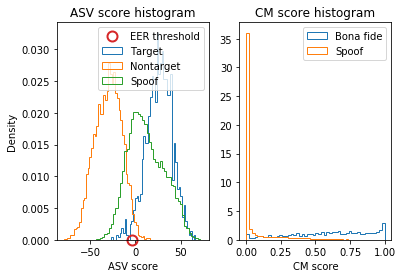

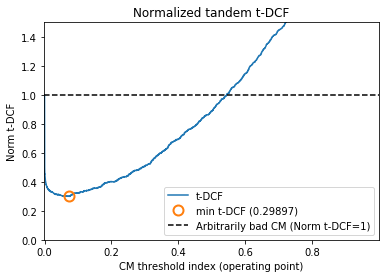

In [163]:
import sys
import numpy as np
# import eval_metrics as em
import matplotlib.pyplot as plt

# Fix tandem detection cost function (t-DCF) parameters
Pspoof = 0.05
cost_model = {
    'Pspoof': Pspoof,  # Prior probability of a spoofing attack
    'Ptar': (1 - Pspoof) * 0.99,  # Prior probability of target speaker
    'Pnon': (1 - Pspoof) * 0.01,  # Prior probability of nontarget speaker
    'Cmiss_asv': 1,  # Cost of ASV system falsely rejecting target speaker
    'Cfa_asv': 10,  # Cost of ASV system falsely accepting nontarget speaker
    'Cmiss_cm': 1,  # Cost of CM system falsely rejecting target speaker
    'Cfa_cm': 10,  # Cost of CM system falsely accepting spoof
}

for i in range(len(cm_keys)):
    if cm_keys[i] == 'bonafide':
        continue
    else:
        cm_keys[i] = 'spoof'

# Extract target, nontarget, and spoof scores from the ASV scores
tar_asv = asv_scores[asv_keys == 'target']
non_asv = asv_scores[asv_keys == 'nontarget']
spoof_asv = asv_scores[asv_keys == 'spoof']

# Extract bona fide (real human) and spoof scores from the CM scores
bona_cm = cm_scores[cm_keys == 'bonafide']
spoof_cm = cm_scores[cm_keys == 'spoof']

# EERs of the standalone systems and fix ASV operating point to EER threshold
eer_asv, asv_threshold = compute_eer(tar_asv, non_asv)
eer_cm = compute_eer(bona_cm, spoof_cm)[0]
# print(cm_keys,bona_cm,spoof_cm)
# sys.exit()

[Pfa_asv, Pmiss_asv, Pmiss_spoof_asv] = obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold)

# Compute t-DCF
tDCF_curve, CM_thresholds = compute_tDCF(bona_cm, spoof_cm, Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, cost_model, True)

# Minimum t-DCF
min_tDCF_index = np.argmin(tDCF_curve)
min_tDCF = tDCF_curve[min_tDCF_index]


print('ASV SYSTEM')
print('   EER            = {:8.5f} % (Equal error rate (target vs. nontarget discrimination)'.format(eer_asv * 100))
print('   Pfa            = {:8.5f} % (False acceptance rate of nontargets)'.format(Pfa_asv * 100))
print('   Pmiss          = {:8.5f} % (False rejection rate of targets)'.format(Pmiss_asv * 100))
print('   1-Pmiss,spoof  = {:8.5f} % (Spoof false acceptance rate)'.format((1 - Pmiss_spoof_asv) * 100))

print('\nCM SYSTEM')
print('   EER            = {:8.5f} % (Equal error rate for countermeasure)'.format(eer_cm * 100))

print('\nTANDEM')
print('   min-tDCF       = {:8.5f}'.format(min_tDCF))


# Visualize ASV scores and CM scores
plt.figure()
ax = plt.subplot(121)
plt.hist(tar_asv, histtype='step', density=True, bins=50, label='Target')
plt.hist(non_asv, histtype='step', density=True, bins=50, label='Nontarget')
plt.hist(spoof_asv, histtype='step', density=True, bins=50, label='Spoof')
plt.plot(asv_threshold, 0, 'o', markersize=10, mfc='none', mew=2, clip_on=False, label='EER threshold')
plt.legend()
plt.xlabel('ASV score')
plt.ylabel('Density')
plt.title('ASV score histogram')

ax = plt.subplot(122)
plt.hist(bona_cm, histtype='step', density=True, bins=50, label='Bona fide')
plt.hist(spoof_cm, histtype='step', density=True, bins=50, label='Spoof')
plt.legend()
plt.xlabel('CM score')
#plt.ylabel('Density')
plt.title('CM score histogram')


# Plot t-DCF as function of the CM threshold.
plt.figure()
plt.plot(CM_thresholds, tDCF_curve)
plt.plot(CM_thresholds[min_tDCF_index], min_tDCF, 'o', markersize=10, mfc='none', mew=2)
plt.xlabel('CM threshold index (operating point)')
plt.ylabel('Norm t-DCF');
plt.title('Normalized tandem t-DCF')
plt.plot([np.min(CM_thresholds), np.max(CM_thresholds)], [1, 1], '--', color='black')
plt.legend(('t-DCF', 'min t-DCF ({:.5f})'.format(min_tDCF), 'Arbitrarily bad CM (Norm t-DCF=1)'))
plt.xlim([np.min(CM_thresholds), np.max(CM_thresholds)])
plt.ylim([0, 1.5])

plt.show()
